In [120]:
import numpy as np
import torch as th
import torch as th
import pandas as pd
import os, glob, sys, tqdm
from collections import defaultdict
from PIL import Image
sys.path.append('/home/mint/Dev/DiFaReli/difareli-faster/sample_scripts/sample_utils/')
import mani_utils


def sh_to_ld(sh):
    #NOTE: Roughly Convert the SH to light direction
    sh = sh.reshape(-1, 9, 3)
    ld = th.mean(sh[0:1, 1:4, :], dim=2)
    return ld

def read_params(path):
    params = pd.read_csv(path, header=None, sep=" ", index_col=False, lineterminator='\n')
    params.rename(columns={0:'img_name'}, inplace=True)
    params = params.set_index('img_name').T.to_dict('list')
    return params

def swap_key(params):
    params_s = defaultdict(dict)
    for params_name, v in params.items():
        for img_name, params_value in v.items():
            params_s[img_name][params_name] = np.array(params_value).astype(np.float64)

    return params_s

def load_deca_params(deca_dir, cfg):
    deca_params = {}

    # face params 
    params_key = ['shape', 'pose', 'exp', 'cam', 'light', 'faceemb', 'shadow', 'albedo', 'detail']
    for k in tqdm.tqdm(params_key, desc="Loading deca params..."):
        params_path = glob.glob(f"{deca_dir}/*{k}-anno.txt")
        for path in params_path:
            deca_params[k] = read_params(path=path)
    
    deca_params = swap_key(deca_params)
    return deca_params

def create_image_grid(images, n_rows=1):
    """
    Creates a grid of images from a list of NumPy arrays.
    
    Parameters:
    - images: List of np.array, each representing an image.
    - n_rows: Number of rows in the grid.
    
    Returns:
    - A matplotlib figure containing the image grid.
    """
    n_images = len(images)
    n_cols = (n_images + n_rows - 1) // n_rows  # Calculate number of columns needed
    
    # Get the height and width of the images (assuming all images are the same size)
    # img_height, img_width = images[0].shape[:2]

    # Add zero images if the number of images is less than needed to fill the grid
    images += [np.zeros_like(images[0]) for _ in range(n_rows * n_cols - n_images)]
    
    # Create the grid by concatenating images
    rows = []
    for i in range(n_rows):
        row_images = images[i * n_cols:(i + 1) * n_cols]
        rows.append(np.concatenate(row_images, axis=1))
    
    grid_image = np.concatenate(rows, axis=0)
    return grid_image

In [121]:
pth = '/data/mint/DPM_Dataset/ffhq_256_with_anno/params/'
set_ = 'valid'

In [122]:
sys.path.append('/home/mint/Dev/DiFaReli/difareli-faster/sample_scripts/sample_utils/')
import params_utils
params = load_deca_params(deca_dir=f'{pth}/{set_}/', cfg=None)
mask = params_utils.load_flame_mask(['face'])
deca_obj = params_utils.init_deca(mask=mask)


img_name = '60065.jpg'
src_idx = 0
cond = {}
for k in params[img_name].keys():
    cond[k] = params[img_name][k][None, ]

for k in cond.keys():
    cond[k] = th.tensor(cond[k]).cuda()
    print(k, cond[k].shape)

cond['raw_image_path'] = [f'/data/mint/DPM_Dataset/ffhq_256_with_anno/ffhq_256/{set_}/{img_name}']
cond['raw_image'] = th.tensor(np.array(Image.open(cond['raw_image_path'][0]))).cuda().permute(2, 0, 1).float().unsqueeze(0)/255.0
deca_rendered, orig_visdict = params_utils.render_deca(deca_params=cond, 
                                                    idx=src_idx, n=1, 
                                                    avg_dict=None, 
                                                    render_mode='shape', 
                                                    rotate_normals=False, 
                                                    mask=mask,
                                                    deca_obj=deca_obj,
                                                    repeat=True)


Loading deca params...: 100%|██████████| 9/9 [00:05<00:00,  1.77it/s]


creating the FLAME Decoder
[#] DECA : SRenderY applied mask
shape torch.Size([1, 100])
pose torch.Size([1, 6])
exp torch.Size([1, 50])
cam torch.Size([1, 3])
light torch.Size([1, 27])
faceemb torch.Size([1, 512])
shadow torch.Size([1, 1])
albedo torch.Size([1, 50])
detail torch.Size([1, 128])
1 1


/home/mint/Dev/DiFaReli/difareli-faster/sample_scripts/sample_utils/params_utils.py:243: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



[#] There's 1 faces detected, using face 0
[#] There's 1 faces detected, using face 0


In [173]:
def sh_to_ld(sh):
    #NOTE: Roughly Convert the SH to light direction
    sh = sh.reshape(-1, 9, 3)
    ld = th.mean(sh[0:1, 1:4, :], dim=2)
    return ld

def sh_to_ld_brightest(sh):
    from scipy.spatial.transform import Rotation as R
    from matplotlib import pyplot as plt
    import cv2

    import pyshtools as pysh

    def applySHlight(normal_images, sh_coeff):
        N = normal_images
        sh = th.stack(
            [
            N[0] * 0.0 + 1.0,
            N[0],
            N[1],
            N[2],
            N[0] * N[1],
            N[0] * N[2],
            N[1] * N[2],
            N[0] ** 2 - N[1] ** 2,
            3 * (N[2] ** 2) - 1,
            ],
            0,
        )  # [9, h, w]
        pi = np.pi
        constant_factor = th.tensor(
            [
            1 / np.sqrt(4 * pi),
            ((2 * pi) / 3) * (np.sqrt(3 / (4 * pi))),
            ((2 * pi) / 3) * (np.sqrt(3 / (4 * pi))),
            ((2 * pi) / 3) * (np.sqrt(3 / (4 * pi))),
            (pi / 4) * (3) * (np.sqrt(5 / (12 * pi))),
            (pi / 4) * (3) * (np.sqrt(5 / (12 * pi))),
            (pi / 4) * (3) * (np.sqrt(5 / (12 * pi))),
            (pi / 4) * (3 / 2) * (np.sqrt(5 / (12 * pi))),
            (pi / 4) * (1 / 2) * (np.sqrt(5 / (4 * pi))),
            ]
        ).float()
        sh = sh * constant_factor[:, None, None]

        shading = th.sum(
            sh_coeff[:, :, None, None] * sh[:, None, :, :], 0
        )  # [9, 3, h, w]
        return shading

    def applySHlightXYZ(xyz, sh):
        out = applySHlight(xyz, sh)
        # out /= pt.max(out)
        out *= 0.7
        return th.clip(out, 0, 1)

    def genSurfaceNormals(n):
        x = th.linspace(-1, 1, n)
        y = th.linspace(1, -1, n)
        y, x = th.meshgrid(y, x)

        z = (1 - x ** 2 - y ** 2)
        z[z < 0] = 0
        z = th.sqrt(z)
        return th.stack([x, y, z], 0)

    def drawSphere(sh, img_size=256):
        n = img_size
        xyz = genSurfaceNormals(n)
        out = applySHlightXYZ(xyz, sh)
        out[:, xyz[2] == 0] = 0
        return out, xyz
    
    sh = sh.reshape(-1, 9, 3)[0]
    visible_sphere, normals_sphere = drawSphere(sh)
    visible_sphere = visible_sphere.permute(1, 2, 0).cpu().numpy()
    # plt.imshow(visible_sphere)
    # plt.show()
    # Locate the brightest point
    visible_sphere_draw = (visible_sphere.copy() * 255).astype(np.uint8)
    
    # Gray scale
    # visible_sphere_tmp = cv2.cvtColor(visible_sphere_draw, cv2.COLOR_RGB2GRAY)
    # brightest = np.unravel_index(visible_sphere_tmp.argmax(), visible_sphere_tmp.shape)
    
    # RGB
    visible_sphere_tmp = visible_sphere_draw.sum(axis=2)
    brightest = np.unravel_index(visible_sphere_tmp.argmax(), visible_sphere_tmp.shape)
    cv2.circle(visible_sphere_draw, (brightest[1], brightest[0]), 5, (255, 0, 0), -1)
    # print(visible_sphere_draw.shape)
    # print(brightest)
    
    # plt.imshow(visible_sphere_draw, cmap='gray')
    # plt.show()
    # cv2.circle(visible_sphere_draw, (brightest[1], brightest[0]), 5, (0, 0, 255), -1)
    # plt.imshow(visible_sphere_draw, cmap='gray')
    # plt.show()
    # Center is at (128, 128)
    # light direction is vector from center to brightest point, aka the index in normal_sphere
    
    normals_sphere = normals_sphere.permute(1, 2, 0).cpu().numpy()
    light_direction = normals_sphere[brightest[0], brightest[1]]
    
    import plotly.graph_objects as go
    
    # fig = go.Figure()
    # fig.add_trace(go.Scatter3d(x=normals_sphere[:, :, 0].flatten(),
    #                            y=normals_sphere[:, :, 1].flatten(),
    #                            z=normals_sphere[:, :, 2].flatten(),
    #                            mode='markers',
    #                            marker=dict(size=0.5),
    #                            name='Sphere'))
    # fig.add_trace(go.Scatter3d(x=[0, light_direction[0]], y=[0, light_direction[1]], z=[0, light_direction[2]], 
    #                            mode='markers+lines', marker=dict(size=5), name='Light Direction'))
    # fig.show()
    return th.tensor(light_direction)[None, ...], (normals_sphere, visible_sphere, visible_sphere_draw)

/tmp/ipykernel_5747/2663865391.py:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


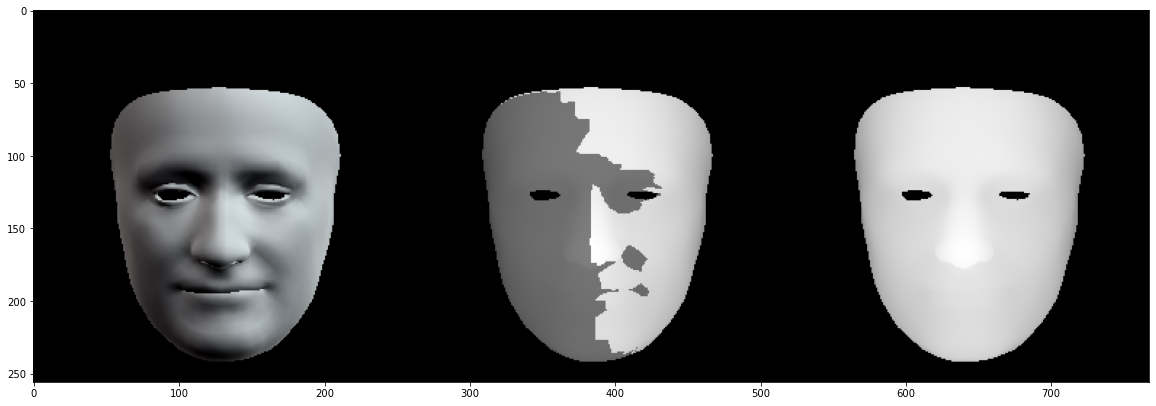

In [177]:
def render_shadow_mask(sh_light, cam, verts, deca):
    sys.path.insert(0, '/home/mint/guided-diffusion/sample_scripts/cond_utils/DECA/')
    from decalib.utils import util
    
    shadow_mask_all = []
    if verts.shape[0] >= 2:
        tmp = []
        for i in range(1, verts.shape[0]):
            tmp.append(th.allclose(verts[[0]], verts[[i]]))
        assert all(tmp)
        
    depth_image, alpha_image = deca.render.render_depth(verts.cuda())   # Depth : B x 1 x H x W
    _, _, h, w = depth_image.shape
    depth_grid = np.meshgrid(np.arange(h), np.arange(w), indexing='xy')
    depth_grid = np.repeat(np.stack((depth_grid), axis=-1)[None, ...], repeats=sh_light.shape[0], axis=0)   # B x H x W x 2
    depth_grid = np.concatenate((depth_grid, depth_image.permute(0, 2, 3, 1)[..., 0:1].cpu().numpy()), axis=-1) # B x H x W x 3
    depth_grid[..., 2] *= 256
    depth_grid = th.tensor(depth_grid).cuda()
    shadow_mask = th.clone(depth_grid[:, :, :, 2])  # Clone the depth image to get the shadow mask
    for i in range(sh_light.shape[0]):
        each_depth_grid = depth_grid[i].clone()
        #NOTE: Render the shadow mask from light direction
        # ld = sh_to_ld(sh=th.tensor(sh_light[[i]])).cuda()
        ld, misc = sh_to_ld_brightest(sh=th.tensor(sh_light[[i]]).cpu())
        ld = ld.cuda()
        ld = util.batch_orth_proj(ld[None, ...], cam[None, ...].cuda()) # Project the light direction to the camera space (# This fn takes pts=Bx3, cam=Bx3)
        ld[:,:,1] = -ld[:,:,1]
        # ld[:,:,1:] = -ld[:,:,1:]
        ray = ld.view(3).cuda()
        ray[2] *= 0.5
        n = 256
        ray = ray / th.norm(ray)    # Normalize the ray
        mxaxis = max(abs(ray[0]), abs(ray[1]))
        shift = ray / mxaxis * th.arange(n).view(n, 1).cuda()   # Aligning the ray with the grid
        coords = each_depth_grid.view(1, n, n, 3) + shift.view(n, 1, 1, 3)# * 0.01
        output = th.nn.functional.grid_sample(
            input=th.tensor(np.tile(each_depth_grid[:, :, 2].view(1, 1, n, n).cpu().numpy(), [n, 1, 1, 1])).cuda(),
            grid=coords[..., :2] / (n - 1) * 2 - 1,
            align_corners=True)
        diff = coords[..., 2] - output[:, 0] 
        shadow_mask[i] *= (th.min(diff, dim=0)[0] > -0.1) * 0.5 + 0.5
        
    return th.clip(shadow_mask, 0, 255.0)/255.0, depth_image, depth_grid, diff, misc, ld

tmp_light = cond['light'].cpu().numpy()
rotate_sh = mani_utils.rotate_sh({'light':tmp_light}, src_idx=0, n_step=60, axis=1)

shadow_mask, depth_image, depth_grid, diff, _, _ = render_shadow_mask(
                sh_light=cond['light'], 
                cam=cond['cam'][src_idx],
                verts=orig_visdict['trans_verts_orig'], 
                deca=deca_obj)

import matplotlib.pyplot as plt
shadow_mask = shadow_mask.cpu().numpy().transpose(1, 2, 0)
shadow_mask = np.repeat(shadow_mask, 3, axis=-1)
depth_image = depth_image[0].cpu().numpy().transpose(1, 2, 0)
depth_image = np.repeat(depth_image, 3, axis=-1)
depth_grid = depth_grid[0].cpu().numpy()
deca_ren = deca_rendered[0].cpu().numpy().transpose(1, 2, 0)
diff = diff[0:1].cpu().numpy().transpose(1, 2, 0)
diff = np.repeat(diff, 3, axis=-1)

fig = plt.figure(figsize=(20, 10))
plt.imshow(create_image_grid([deca_ren, shadow_mask, depth_image], n_rows=1))
plt.show()

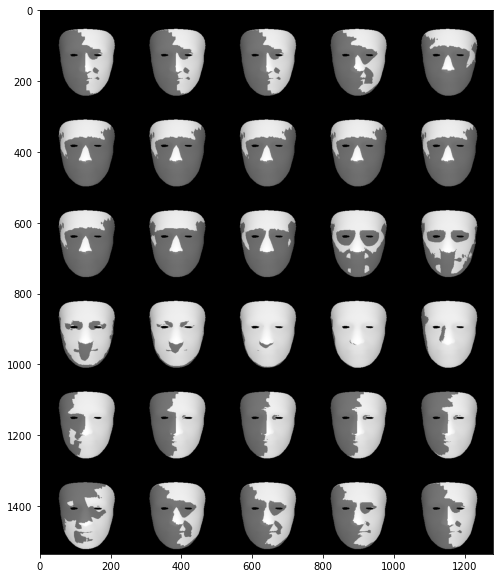

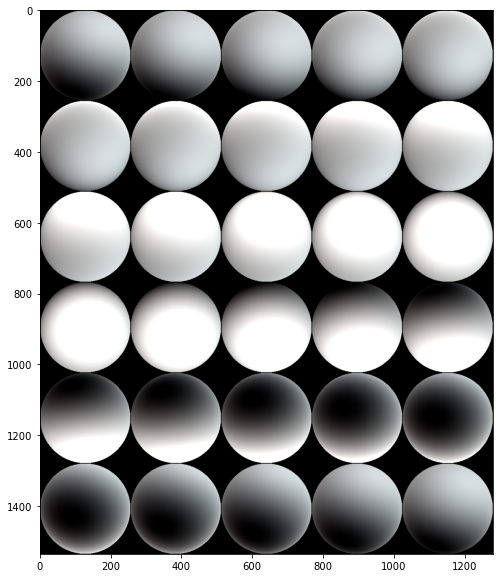

1.0 0.0
1.0 0.0
1.0 0.0


In [180]:
tmp_light = cond['light'].cpu().numpy()
rotate_sh = mani_utils.rotate_sh({'light':tmp_light}, src_idx=0, n_step=30, axis=0)

out_sd = []
out_nm = []
out_vs = []
out_vsd = []

for i in range(rotate_sh['light'].shape[0]):
    shadow_mask, depth_image, depth_grid, diff, misc, ld = render_shadow_mask(
                sh_light=rotate_sh['light'][[i]], 
                cam=cond['cam'][src_idx],
                verts=orig_visdict['trans_verts_orig'],
                deca=deca_obj)
    
    normals_sphere, visible_sphere, visible_sphere_draw = misc
    sd = shadow_mask.cpu().numpy().transpose(1, 2, 0)
    sd = np.repeat(sd, 3, axis=-1)
    out_sd.append(sd)
    out_nm.append(normals_sphere)
    out_vs.append(visible_sphere)
    out_vsd.append(visible_sphere_draw)
    

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20, 10))
n_rows=10
plt.imshow(create_image_grid(out_sd, n_rows=60//n_rows))
plt.show()

fig = plt.figure(figsize=(20, 10))
plt.imshow(create_image_grid(out_vs, n_rows=60//n_rows))
plt.show()

import torchvision
out_sd = np.stack(out_sd)
out_nm = np.stack(out_nm)
out_vs = np.stack(out_vs)
out_vsd = np.stack(out_vsd)/255.

print(np.max(out_sd), np.min(out_sd))
print(np.max(out_vs), np.min(out_vs))
print(np.max(out_vsd), np.min(out_vsd))

out = np.concatenate([out_sd, out_vs, out_vsd], axis=2)

torchvision.io.write_video('shadow_mask.mp4', th.tensor(np.stack(out_sd))*255, fps=30)
torchvision.io.write_video('out.mp4', out*255, fps=30)

# Render shadow mask by rotate the light direction

In [ ]:

def render_shadow_mask(sh_light, cam, verts, deca):
    sys.path.insert(0, '/home/mint/guided-diffusion/sample_scripts/cond_utils/DECA/')
    from decalib.utils import util
    
    shadow_mask_all = []
    if verts.shape[0] >= 2:
        tmp = []
        for i in range(1, verts.shape[0]):
            tmp.append(th.allclose(verts[[0]], verts[[i]]))
        assert all(tmp)
        
    depth_image, alpha_image = deca.render.render_depth(verts.cuda())   # Depth : B x 1 x H x W
    _, _, h, w = depth_image.shape
    depth_grid = np.meshgrid(np.arange(h), np.arange(w), indexing='xy')
    depth_grid = np.repeat(np.stack((depth_grid), axis=-1)[None, ...], repeats=sh_light.shape[0], axis=0)   # B x H x W x 2
    depth_grid = np.concatenate((depth_grid, depth_image.permute(0, 2, 3, 1)[..., 0:1].cpu().numpy()), axis=-1) # B x H x W x 3
    depth_grid[..., 2] *= 256
    depth_grid = th.tensor(depth_grid).cuda()
    shadow_mask = th.clone(depth_grid[:, :, :, 2])  # Clone the depth image to get the shadow mask
    
    ld, misc = sh_to_ld_brightest(sh=th.tensor(sh_light[[0]]).cpu())    # Get the light direction of input SH
    
    
    for i in range(sh_light.shape[0]):
        each_depth_grid = depth_grid[i].clone()
        #NOTE: Render the shadow mask from light direction
        # ld = sh_to_ld(sh=th.tensor(sh_light[[i]])).cuda()
        ld = ld.cuda()
        ld = util.batch_orth_proj(ld[None, ...], cam[None, ...].cuda()) # Project the light direction to the camera space (# This fn takes pts=Bx3, cam=Bx3)
        ld[:,:,1] = -ld[:,:,1]
        # ld[:,:,1:] = -ld[:,:,1:]
        ray = ld.view(3).cuda()
        ray[2] *= 0.5
        n = 256
        ray = ray / th.norm(ray)    # Normalize the ray
        mxaxis = max(abs(ray[0]), abs(ray[1]))
        shift = ray / mxaxis * th.arange(n).view(n, 1).cuda()   # Aligning the ray with the grid
        coords = each_depth_grid.view(1, n, n, 3) + shift.view(n, 1, 1, 3)# * 0.01
        output = th.nn.functional.grid_sample(
            input=th.tensor(np.tile(each_depth_grid[:, :, 2].view(1, 1, n, n).cpu().numpy(), [n, 1, 1, 1])).cuda(),
            grid=coords[..., :2] / (n - 1) * 2 - 1,
            align_corners=True)
        diff = coords[..., 2] - output[:, 0] 
        shadow_mask[i] *= (th.min(diff, dim=0)[0] > -0.1) * 0.5 + 0.5
        
    return th.clip(shadow_mask, 0, 255.0)/255.0, depth_image, depth_grid, diff, misc, ld

tmp_light = cond['light'].cpu().numpy()
rotate_sh = mani_utils.rotate_sh({'light':tmp_light}, src_idx=0, n_step=60, axis=1)

shadow_mask, depth_image, depth_grid, diff, _, _ = render_shadow_mask(
                sh_light=cond['light'], 
                cam=cond['cam'][src_idx],
                verts=orig_visdict['trans_verts_orig'], 
                deca=deca_obj)

import matplotlib.pyplot as plt
shadow_mask = shadow_mask.cpu().numpy().transpose(1, 2, 0)
shadow_mask = np.repeat(shadow_mask, 3, axis=-1)
depth_image = depth_image[0].cpu().numpy().transpose(1, 2, 0)
depth_image = np.repeat(depth_image, 3, axis=-1)
depth_grid = depth_grid[0].cpu().numpy()
deca_ren = deca_rendered[0].cpu().numpy().transpose(1, 2, 0)
diff = diff[0:1].cpu().numpy().transpose(1, 2, 0)
diff = np.repeat(diff, 3, axis=-1)

fig = plt.figure(figsize=(20, 10))
plt.imshow(create_image_grid([deca_ren, shadow_mask, depth_image], n_rows=1))
plt.show()

In [ ]:
tmp_light = cond['light'].cpu().numpy()
rotate_sh = mani_utils.rotate_sh({'light':tmp_light}, src_idx=0, n_step=30, axis=0)

out_sd = []
out_nm = []
out_vs = []
out_vsd = []

for i in range(rotate_sh['light'].shape[0]):
    shadow_mask, depth_image, depth_grid, diff, misc, ld = render_shadow_mask_rotate_ld(
                sh_light=rotate_sh['light'][[i]], 
                cam=cond['cam'][src_idx],
                verts=orig_visdict['trans_verts_orig'],
                deca=deca_obj)
    
    normals_sphere, visible_sphere, visible_sphere_draw = misc
    sd = shadow_mask.cpu().numpy().transpose(1, 2, 0)
    sd = np.repeat(sd, 3, axis=-1)
    out_sd.append(sd)
    out_nm.append(normals_sphere)
    out_vs.append(visible_sphere)
    out_vsd.append(visible_sphere_draw)
    

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20, 10))
n_rows=10
plt.imshow(create_image_grid(out_sd, n_rows=60//n_rows))
plt.show()

fig = plt.figure(figsize=(20, 10))
plt.imshow(create_image_grid(out_vs, n_rows=60//n_rows))
plt.show()

import torchvision
out_sd = np.stack(out_sd)
out_nm = np.stack(out_nm)
out_vs = np.stack(out_vs)
out_vsd = np.stack(out_vsd)/255.

print(np.max(out_sd), np.min(out_sd))
print(np.max(out_vs), np.min(out_vs))
print(np.max(out_vsd), np.min(out_vsd))

out = np.concatenate([out_sd, out_vs, out_vsd], axis=2)

torchvision.io.write_video('shadow_mask.mp4', th.tensor(np.stack(out_sd))*255, fps=30)
torchvision.io.write_video('out.mp4', out*255, fps=30)